### This notebook will solve part 1 of lab 2 for the KTH ANN course

### 3.1 - Batch RBF

Functions

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt

def sample_sin(start, end, step):
    count = int((end - start) // step + 1)
    data = np.array([math.sin(2*(start + step * i)) for i in range(count)])
    data = data.reshape((count, 1))
    return data

def sample_square(start, end, step):
    sample = sample_sin(start, end, step)
    sample = np.where(sample >= 0, 1, -1)
    sample = sample.reshape((sample.shape[0], 1))
    return sample
  
def gaussian(x, center, sigma):
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def calculate_rbf(x, centers, sigma):
    return np.array([gaussian(x, c, sigma) for c in centers]).T

def train_rbf(X, Y, centers, sigma):
    phi = calculate_rbf(X, centers, sigma)
    # pseudo inverse to get weights that minimize mse
    weights = np.linalg.pinv(phi) @ Y
    return weights

def predict_rbf(X, centers, sigma, weights):
    phi = calculate_rbf(X, centers, sigma)
    return phi @ weights
  
def plot_predictions(x, actual_y, predicted_y, title, name, centers):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, actual_y, color='blue', label='Actual')
    plt.scatter(x, predicted_y, color='red', label='Predicted')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    # plt.show()
    plt.tight_layout()  # Add this line
    plt.savefig('imgs/'+name +str(len(centers))+ '.png')
    
def get_labels():
    train_sin = sample_sin(0, math.pi * 2, 0.1)
    test_sin = sample_sin(0.05, math.pi * 2, 0.1)
    train_square = sample_square(0, math.pi * 2, 0.1)
    test_square = sample_square(0.05, math.pi * 2, 0.1)
    train_x = np.arange(0, math.pi * 2, 0.1)
    test_x = np.arange(0.05, math.pi * 2, 0.1)
    return train_x,test_x,train_sin, test_sin, train_square, test_square
  

def compute_error(actual, predicted):
  return np.mean(np.absolute(actual - predicted))
  
def evaluate(name, train_x, train_y,test_x, test_y,centers, sigma):
    weights = train_rbf(train_x, train_y, centers, sigma)
    train_pred = predict_rbf(train_x, centers, sigma, weights)
    train_error = compute_error(train_y, train_pred)
    test_pred = predict_rbf(test_x, centers, sigma, weights)
    test_error = compute_error(test_y, train_pred)
    print(f'Train error ({name}):', train_error)
    print(f'Test error ({name}):', test_error)
    plot_predictions(test_x, test_y, test_pred, f'Predictions vs Actual for {name}(2x)', name, centers)
    

In [ ]:
step = 2*math.pi/61
print(step)

start, end, step = 0, 2*math.pi,step
centers = np.arange(start, end, step)
centers = [0.25*math.pi, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]
sigma = 0.5

train_x,test_x,sin_y_train, sin_y_test, train_y_square, test_y_square = get_labels()
evaluate('sin', train_x, sin_y_train,test_x, sin_y_test,centers, sigma)
evaluate('square', train_x, train_y_square,test_x, test_y_square,centers, sigma)



### 3.2 - Online RBF

In [9]:
def sample_sin(start, end, step):
    count = int((end - start) // step + 1)
    data = np.array([math.sin(start + step * i) for i in range(count)])
    data = data.reshape((count, 1))
    return data

def sample_square(start, end, step):
    sample = sample_sin(start, end, step)
    sample = np.where(sample >= 0, 1, -1)
    sample = sample.reshape((sample.shape[0], 1))
    return sample

# Function for adding Gaussian noise
def add_noise(y, variance):
    noise = np.random.normal(0, np.sqrt(variance), y.shape)
    return y + noise

# Function for updating weights with delta rule
def update_weights(weights, eta, error, phi):
    return weights + eta * error * phi

# RBF and training functions
def calculate_rbf(x, centers, sigma):
    return np.array([gaussian(x, c, sigma) for c in centers]).T

def train_rbf_online(X, Y, centers, sigma, eta, epochs):
    weights = np.random.rand(len(centers), 1)
    for epoch in range(epochs):
        p = np.random.permutation(X.shape[0])
        X, Y = X[p], Y[p]
        for i in range(X.shape[0]):
            phi = calculate_rbf(X[i], centers, sigma).reshape(-1, 1)
            y_pred = phi.T @ weights
            error = Y[i] - y_pred
            weights = update_weights(weights, eta, error, phi)
    return weights

def predict_rbf(X, centers, sigma, weights):
    phi = calculate_rbf(X, centers, sigma)
    return phi @ weights

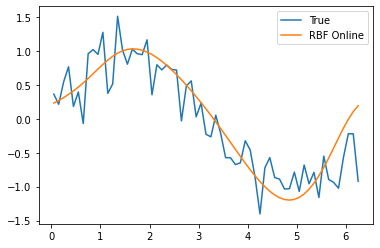

Test error (online learning, 10 centers, width 0.5): 0.11546979688143418


In [21]:
# Define parameters
start, end, step = 0, 2*math.pi, 0.1
sigma = 0.5 # Width of the RBF nodes
eta = 0.01 # Learning rate
epochs = 100 # Number of epochs
n_centers = 10 # Number of RBF nodes

# Generate training and testing datasets
sin_train_x = np.arange(start, end, step)
sin_train_y = sample_sin(start, end, step)
sin_test_x = np.arange(start + 0.05, end, step)
sin_test_y = sample_sin(start + 0.05, end, step)

# Add noise to the datasets
sin_train_y_noise = add_noise(sin_train_y, 0.1)
sin_test_y_noise = add_noise(sin_test_y, 0.1)

# Train the RBF network using on-line learning
centers = np.linspace(start, end, n_centers)
weights_online = train_rbf_online(sin_train_x, sin_train_y_noise, centers, sigma, eta, epochs)

# Make predictions on the test set
y_pred_online = predict_rbf(sin_test_x, centers, sigma, weights_online)

# Plot the results
plt.figure()
plt.plot(sin_test_x, sin_test_y_noise, label='True')
plt.plot(sin_test_x, y_pred_online, label='RBF Online')
plt.legend()
plt.show()

# Print the mean squared error
print(f"Test error (online learning, {n_centers} centers, width {sigma}):", np.mean((sin_test_y_noise - y_pred_online)**2))